In [1]:
%env THEANO_FLAGS=mode=FAST_RUN,device=gpu0
import sys
sys.path.insert(0,'../')

import network
reload(network)

net = network.Net()
net.change_lr(0.01)

env: THEANO_FLAGS=mode=FAST_RUN,device=gpu0


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


In [2]:
import data_loader
reload(data_loader)

from data_loader import DataLoader

classes = [wnid.strip() for wnid in open('../all_synsets.txt').readlines()]
dataset = DataLoader( '../../ilsvrc2012','/home/nine/workspace/caffe/data/ilsvrc12/train.txt','/home/nine/workspace/caffe/data/ilsvrc12/val.txt')

In [3]:
from PIL import Image
import preprocessor
reload(preprocessor)
from preprocessor import Fetcher
import tree_distance
reload(tree_distance)
from tree_distance import Distance
import cPickle as pickle

mean = pickle.load(open('mean.pkl'))
fetcher = Fetcher('center',mean)
distance = Distance('../wordnet.is_a.txt','../all_synsets.txt')

In [4]:
def net_surgery() :
    import lasagne
    import cPickle as pickle
    
    vals = pickle.load(open('../../models/vgg_cnn_s.pkl'))['values']
    original_vals = lasagne.layers.get_all_param_values(net.net['fc8'])
    new_vals = []
    for i in range(14):
        new_vals.append(vals[i])
    for i in range(14,16):
        new_vals.append(original_vals[i])
    pickle.dump(new_vals,open('trained.pkl','wb'))
net_surgery()

In [5]:
#net.load_model('trained.pkl')
#pickle.dump(pickle.load(open('../../models/vgg_cnn_s.pkl'))['values'],open('trained.pkl','wb'))
net.load_model('trained.pkl')

In [6]:
from multiprocessing import Pool, Process, Queue, Value
import sys, datetime

def fetch(q,max_buf,flag,fetcher,distance) :
    import numpy as np
    
    while(flag.value != 0) :
        if( q.qsize() < max_buf ) :
            fetched = dataset.fetch_train(128)

            ims = fetcher.fetch(fetched)
            target_prob = np.zeros((128,1860),np.float32)
            
            def get_target_prob() :
                for i,(leaf_label,_) in enumerate(fetched) :
                    target_prob[i,...] = distance.get_target_prob(leaf_label)
            get_target_prob()
            
            q.put((ims,target_prob))
            
#             import datetime
#             print 'Enqueued', datetime.datetime.now()
#             sys.stdout.flush()
            
q = Queue()
flag = Value('d', 1) 
p = Process(target=fetch,args=(q,10,flag,fetcher,distance))

p.start()

import logging
logging.basicConfig(filename='train.log',level=logging.DEBUG)

net.change_lr(0.001)
for i in range(100000):
    ims,target_prob = q.get()
    loss = net.train(ims,target_prob)
    
    import datetime
#     print 'Trained', datetime.datetime.now()
#     sys.stdout.flush()
    if i % 10 == 0 :
        log = "{},{},{}".format(datetime.datetime.now(), i, loss)
        print log
        sys.stdout.flush()
        
        logging.info(log)

flag.value = 0
p.join()

2015-10-02 16:53:31.976420,0,[array(0.004967650398612022, dtype=float32)]
2015-10-02 16:53:51.101096,10,[array(0.005015051923692226, dtype=float32)]
2015-10-02 16:54:10.309204,20,[array(0.004915920551866293, dtype=float32)]
2015-10-02 16:54:29.541896,30,[array(0.0049245706759393215, dtype=float32)]
2015-10-02 16:54:48.807243,40,[array(0.0050235954113304615, dtype=float32)]
2015-10-02 16:55:08.108902,50,[array(0.004854804836213589, dtype=float32)]
2015-10-02 16:55:27.421836,60,[array(0.004945100750774145, dtype=float32)]


KeyboardInterrupt: 

In [15]:
net.save_model('trained.pkl')

n01751748 0.0 1.0
n00001740 0.923087 1.0
n00001930 0.920677 1.0
n00002684 0.884785 1.0
n00021939 0.475212 0.0
n00015388 0.373713 1.0
n01466257 0.314388 1.0
n01861778 0.204487 0.0
n02083346 0.120311 0.0
n03183080 0.115986 0.0
n01767661 0.0446891 0.0
n01661818 0.0290396 1.0
n03676483 0.0 0.0
n03595614 0.0 0.0
n03598930 0.0 0.0
n03690938 0.0 0.0
n03599486 0.0 0.0
n03602883 0.0 0.0
n03617480 0.0 0.0
n03623198 0.0 0.0
n03627232 0.0 0.0
n03630383 0.0 0.0
n03633091 0.0 0.0
n03680355 0.0 0.0
n03673027 0.0 0.0
n03637318 0.0 0.0
n03642806 0.0 0.0
n03649909 0.0 0.0
n03594734 0.0 0.0
n03657121 0.0 0.0
n03658185 0.0 0.0
n03661043 0.0 0.0
n03662601 0.0 0.0
n03666591 0.0 0.0
n03670208 0.0 0.0
n03594945 0.0 0.0
n03538406 0.0 0.0
n03590841 0.0 0.0
n03492542 0.0 0.0
n03459775 0.0 0.0
n03461385 0.0 0.0
n03467068 0.0 0.0
n03476684 0.0 0.0
n03476991 0.0 0.0
n03478589 0.0 0.0
n03481172 0.0 0.0
n03482405 0.0 0.0
n03483316 0.0 0.0
n03485407 0.0 0.0
n03485794 0.0 0.0
n03494278 0.0 0.0
n03584829 0.0 0.0
n034952

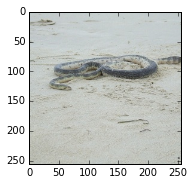

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fetch = dataset.fetch_val(1)

plt.subplot(121)
plt.imshow(Image.open(fetch[0][1]))

prob = net.test(fetcher.fetch(fetch))
print classes[fetch[0][0]], prob[0][0,fetch[0][0]], distance.get_target_prob(fetch[0][0])[fetch[0][0]]

import numpy as np
for ind in prob[0][0,].argsort()[-100:][::-1] :
    print classes[ind], prob[0][0,ind], distance.get_target_prob(fetch[0][0])[ind]
    if( ind == fetch[0][0] ) :
        break